In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("dark")

In [2]:
train = pd.read_csv("../data/train_small.csv")
test = pd.read_csv("../data/test_fe.csv")

In [3]:
train.head()

,temperature,humidity,light,co2,humidityratio,target
0,0.530266,0.850894,0.0,0.778661,0.837370,0.0
1,0.314770,0.633058,0.0,0.415662,0.550666,0.0
2,0.072639,0.035636,0.0,0.007284,0.017525,0.0
3,0.217918,0.149373,0.0,0.099513,0.158298,0.0
4,0.072639,0.030942,0.0,0.011285,0.014351,0.0


In [4]:
x_train_use, y_train_use = train.drop("target", axis = 1), train["target"]

In [5]:
#x_train_use = x_train_use.drop_duplicates().reset_index(drop=True)

In [6]:
train.shape

(1578, 6)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train_use, y_train_use, train_size=0.8, random_state = 42)

In [8]:
x_train.shape, y_train.shape

((1262, 5), (1262,))

### Logistic Regression

In [9]:
lr = LogisticRegression()
lr.fit(x_train, np.array(y_train).reshape(-1,1))

LogisticRegression()

In [10]:
y_pred = lr.predict(x_train)

In [11]:
f1_score(y_train, y_pred)

0.9718631178707224

In [12]:
np.linspace(0,1,10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [13]:
lr_pipeline = Pipeline([("lr", LogisticRegression(solver='saga', max_iter=5000))])
param_grid = [{"lr__C":np.linspace(0,1,10), "lr__penalty":["l1","l2", "elasticnet"]}]
grid_search = GridSearchCV(lr_pipeline, param_grid, cv = 5)

In [14]:
grid_search.fit(x_train, np.array(y_train).reshape(-1,1))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('lr',
                                        LogisticRegression(max_iter=5000,
                                                           solver='saga'))]),
             param_grid=[{'lr__C': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                          'lr__penalty': ['l1', 'l2', 'elasticnet']}])

In [15]:
grid_search.best_params_

{'lr__C': 0.2222222222222222, 'lr__penalty': 'l1'}

In [16]:
model = grid_search.best_estimator_

In [17]:
model.fit(x_train, y_train)

Pipeline(steps=[('lr',
                 LogisticRegression(C=0.2222222222222222, max_iter=5000,
                                    penalty='l1', solver='saga'))])

In [18]:
y_pred = model.predict(x_train)

In [19]:
f1_score(y_train, y_pred)

0.9854851031321619

In [20]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       616
         1.0       0.97      1.00      0.99       646

    accuracy                           0.98      1262
   macro avg       0.99      0.98      0.98      1262
weighted avg       0.99      0.98      0.98      1262



In [21]:
train["target"].value_counts()

0.0    789
1.0    789
Name: target, dtype: int64

In [22]:
import seaborn as sns; sns.set_style("darkgrid")

In [23]:
def plot_confusion_matrix(title,conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()
    plt.savefig("../conf/"+title+".png")

<AxesSubplot:>

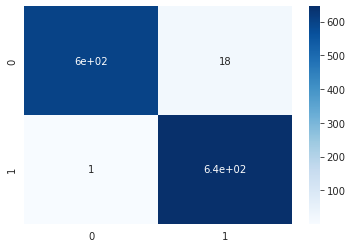

In [24]:
conf = confusion_matrix(y_train, y_pred)
sns.heatmap(conf, annot=True, cmap= "Blues")

In [25]:
y_pred_val = model.predict(x_val)

In [26]:
f1_score(y_val, y_pred_val)

0.9896193771626297

In [27]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       173
         1.0       0.98      1.00      0.99       143

    accuracy                           0.99       316
   macro avg       0.99      0.99      0.99       316
weighted avg       0.99      0.99      0.99       316



#### Extracting results

In [28]:
import time
start = time.time()
model.fit(x_train_use, y_train_use)
elapsed = time.time() - start

In [29]:
pred_use = model.predict(x_train_use)

In [30]:
cross_val_score(model, x_train_use, y_train_use, scoring="f1")

array([0.98125   , 0.99371069, 0.97230769, 0.99367089, 0.99059561])

In [31]:
print(classification_report(y_train_use, pred_use))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99       789
         1.0       0.97      1.00      0.99       789

    accuracy                           0.99      1578
   macro avg       0.99      0.99      0.99      1578
weighted avg       0.99      0.99      0.99      1578



In [32]:
f1_train = f1_score(y_train_use, pred_use)
prec_train = precision_score(y_train_use, pred_use)
recall_train = recall_score(y_train_use, pred_use)

In [33]:
cols=train.columns
cols

Index(['temperature', 'humidity', 'light', 'co2', 'humidityratio', 'target'], dtype='object')

In [34]:
test

,temperature,humidity,light,co2,humidityratio,target
0,0.748184,0.393705,0.344557,0.478995,0.606309,1.0
1,0.610775,0.353961,0.404036,0.542447,0.500649,1.0
2,0.131961,0.048013,0.000000,0.032829,0.050657,0.0
3,0.460048,0.667556,0.322286,0.804309,0.657110,1.0
4,0.329298,0.660443,0.000000,0.460528,0.578445,0.0
...,...,...,...,...,...,...
528,0.142857,0.309416,0.000000,0.093460,0.235343,0.0
529,0.167070,0.365431,0.000000,0.147833,0.285558,0.0
530,0.167070,0.309416,0.000000,0.132598,0.246695,0.0
531,0.737288,0.397439,0.104876,0.570916,0.603294,0.0


In [35]:
x_test, y_test = test.drop("target", axis =1), test["target"]

In [36]:
pred_test = model.predict(x_test)

In [37]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98       350
         1.0       0.93      1.00      0.97       183

    accuracy                           0.98       533
   macro avg       0.97      0.98      0.97       533
weighted avg       0.98      0.98      0.98       533



In [38]:
f1_test = f1_score(y_test, pred_test)
prec_test = precision_score(y_test, pred_test)
recall_test = recall_score(y_test, pred_test)

In [39]:
conf = confusion_matrix(y_test, pred_test)

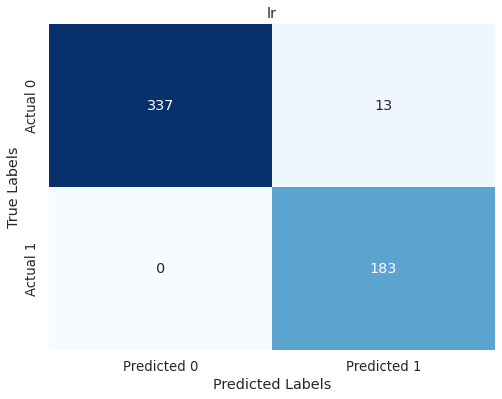

<Figure size 432x288 with 0 Axes>

In [40]:
plot_confusion_matrix("lr",conf)

In [41]:
df = pd.DataFrame()
df["f1_test"] = [f1_test]
df["f1_train"] = f1_train
df["prec_train"] = prec_train
df["prec_test"] = prec_test
df["recall_train"] = recall_train
df["recall_test"] = recall_test
df["model"] = "Logistic Regression"
df["elapsed"] = elapsed

In [42]:
df

,f1_test,f1_train,prec_train,prec_test,recall_train,recall_test,model,elapsed
0,0.965699,0.986233,0.974042,0.933673,0.998733,1.0,Logistic Regression,0.017524


In [43]:
df.to_csv("../results/regular/lr.csv", index=False)

In [44]:
len(test)

533